In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances

# We are in TM-Landscape/scripts/eval → go up two levels to TM-Landscape
PROJECT_ROOT = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path.cwd().parents[1]
sys.path.append(str(PROJECT_ROOT))

In [19]:
from scripts.utils.load_tmvec_embeddings import load_tmvec_embeddings
from scripts.utils.map_tmvec_embeddings import run_tsne, plot_tsne, plot_tsne_overlay
from scripts.utils.sample_tmvec_embeddings import sample_and_save
from scripts.utils.density_estimator import estimate_log_density
from scripts.utils.frequency_estimator import estimate_log_frequency

### Plot T-SNE embeddings of TM-vec trained model

In [12]:
# Load full original embeddings (no sampling here)
Z, meta = load_tmvec_embeddings(source="cath", size="large")

# Then map with sampling 0.05% to 3D
if "tsne_embeddings_cath_3d_prop0.005.csv" in os.listdir("../../data/tsne"):
    print("[INFO] Loading existing t-SNE 3D embeddings from results/tsne_embeddings_cath_3d_prop0.005.csv")
    df = pd.read_csv(PROJECT_ROOT.joinpath("data/tsne/tsne_embeddings_cath_3d_prop0.005.csv"))
else: 
    df = run_tsne(Z, meta, dim=3, perplexity=30, sample_frac=0.005, save_path="../../data/tsne/tsne_embeddings_cath_3d_prop0.005.csv")

plot_tsne(df, dim=3, color_by="metadata")

[INFO] Loading TM-Vec CATH (large) embeddings...
[INFO] Loaded embeddings → shape (500238, 512)

[INFO] Loading existing t-SNE 3D embeddings from results/tsne_embeddings_cath_3d_prop0.005.csv


KeyboardInterrupt: 

### Generate embeddings of input protein with random Monte Carlo sampling to explore embedding diversity for a given sequence

In [ ]:
prot_t5_dir = "../../models/Rostlab/prot_t5_xl_uniref50"
tm_vec_ckpt = "../../models/TM-vec/tm_vec_cath_model_large.ckpt"
tm_vec_json = "../../models/TM-vec/49181518_tm_vec_cath_model_large_params.json"

seq = "MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF"  # your input protein (1VII_1|Chain A|VILLIN|Gallus gallus (9031)) - 35 aa

out = sample_and_save(
    seq,
    prot_t5_dir,
    tm_vec_ckpt,
    tm_vec_json,
    out_path="../../data/embeddings/1VII_soft",
    n_mask=50,
    n_ala=50,
    frac_mask_range=(0.03, 0.06),
    frac_ala_range=(0.03, 0.06),
)

[INFO] Using device: cpu
[INFO] Loading ProtT5 encoder...
[INFO] Loading TM-Vec model...


Lightning automatically upgraded your loaded checkpoint from v1.8.0rc0 to v2.5.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../models/TM-vec/tm_vec_cath_model_large.ckpt`


[INFO] Encoding 101 total sequences via TM-Vec...


100%|██████████| 101/101 [01:07<00:00,  1.51it/s]

[INFO] Saved embeddings → ../../data/embeddings/1VII_very_hard.npz


In [ ]:
# Load your npz file
Z, metadata = load_tmvec_embeddings(source="cath", size="large", frac=0.005)
data = np.load("../../data/embeddings/1VII_very_hard.npz")

# Concatenate all embeddings
Z_original = data["original"].reshape(1, -1)
Z_masked = data["masked"]
Z_ala = data["ala"]

Z_all = np.vstack([Z, Z_original, Z_masked, Z_ala])
labels = (["original_embeddings"] * len(Z) +
          ["new"] * len(Z_original) +
          ["masked"] * len(Z_masked) +
          ["ala"] * len(Z_ala))

print("Z_all:", Z_all.shape, " | labels:", len(labels))

df = run_tsne(
    Z_all,
    metadata=None,
    dim=3,
    perplexity=30,
    sample_frac=1.0,   # full data since you already control sample size
    save_path=None
)
df["Type"] = labels

plot_tsne_overlay(df)

[INFO] Loading TM-Vec CATH (large) embeddings...
[INFO] Subsampled 2501/500238 embeddings (0.5%).
[INFO] Loaded embeddings → shape (2501, 512)

Z_all: (2602, 512)  | labels: 2602
[INFO] Running t-SNE on 2602/2602 samples (dim=3)...


# Nearest Neighbors

### Find nearest neighbor for each new z generated, retrieve its cosine distance and with it its TM-score (~ 1 - dist) to the nearest neighbor z. Then retrieve from this z's their respective CATH ID

[INFO] Loading TM-Vec CATH (large) embeddings...
[INFO] Loaded embeddings → shape (500238, 512)

[INFO] Base embedding set: (500238, 512), Variants total: 101


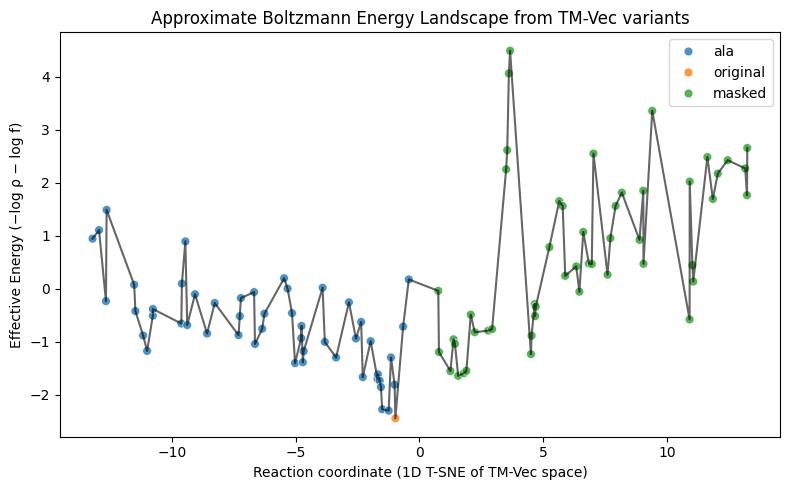

              Log_Density  Log_Frequency  Energy
Variant_Type                                    
ala            335.502014    1618.511963  -0.664
masked         310.585999    1631.623047   0.713
original       328.445007    2353.121094  -2.447


In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import seaborn as sns

# ============================================================
# 1. Load embeddings
# ============================================================
Z, metadata = load_tmvec_embeddings(source="cath", size="large", frac=1)
data = np.load("../../data/embeddings/1VII_hard.npz")

Z_original = data["original"].reshape(1, -1)
Z_masked = data["masked"]
Z_ala = data["ala"]

variant_sets = {
    "original": Z_original,
    "masked": Z_masked,
    "ala": Z_ala
}

print(f"[INFO] Base embedding set: {Z.shape}, Variants total: {sum(len(v) for v in variant_sets.values())}")

# ============================================================
# 2. Collect all variant embeddings and metadata
# ============================================================
records = []
query_embeddings = []
for variant_type, Z_var in variant_sets.items():
    for i in range(len(Z_var)):
        query_embeddings.append(Z_var[i])
        records.append({"Variant_Type": variant_type, "Variant_Index": i})
df = pd.DataFrame(records)
query_embeddings = np.vstack(query_embeddings)

# ============================================================
# 3. Compute log-density (global manifold)
# ============================================================
k_density = 200
log_dens = estimate_log_density(Z_ref=Z,
                                Z_query=query_embeddings,
                                k=k_density,
                                metric="cosine",
                                D_eff=None)
df["Log_Density"] = log_dens

# ============================================================
# 4. Compute log-frequency (local variants)
# ============================================================
# Combine all variants (same space) to estimate local frequency
M = len(query_embeddings)
k_freq = max(5, int(np.sqrt(M)))  # e.g. ~10 for 100 variants
log_freq = estimate_log_frequency(Z_var=query_embeddings,
                                  k=k_freq,
                                  metric="cosine",
                                  D_eff=None)
df["Log_Frequency"] = log_freq

# ============================================================
# 5. Combine into energy estimate
# ============================================================
# Normalize both (z-score)
df["Log_Density_n"] = (df["Log_Density"] - df["Log_Density"].mean()) / df["Log_Density"].std()
df["Log_Frequency_n"] = (df["Log_Frequency"] - df["Log_Frequency"].mean()) / df["Log_Frequency"].std()

alpha, beta = 1.0, 1.0  # weighting factors
df["Energy"] = -(alpha * df["Log_Density_n"] + beta * df["Log_Frequency_n"])

# ============================================================
# 6. Compress to 1D reaction coordinate (T-SNE)
# ============================================================
tsne = TSNE(n_components=1, perplexity=15, metric="cosine", random_state=42)
reaction_coord = tsne.fit_transform(query_embeddings).ravel()
df["Reaction_Coord"] = reaction_coord

# Sort for plotting smooth line
df_sorted = df.sort_values("Reaction_Coord")

# ============================================================
# 7. Plot Energy Landscape
# ============================================================
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_sorted, x="Reaction_Coord", y="Energy",
                hue="Variant_Type", s=40, alpha=0.8)

# smooth line connecting variants (approx. Boltzmann trajectory)
sns.lineplot(data=df_sorted, x="Reaction_Coord", y="Energy",
             color="black", lw=1.5, alpha=0.6)

plt.xlabel("Reaction coordinate (1D T-SNE of TM-Vec space)")
plt.ylabel("Effective Energy (−log ρ − log f)")
plt.title("Approximate Boltzmann Energy Landscape from TM-Vec variants")
plt.tight_layout()
plt.show()

print(df.groupby("Variant_Type")[["Log_Density", "Log_Frequency", "Energy"]].mean().round(3))


In [9]:
from sklearn.metrics.pairwise import cosine_distances

dist_masked = cosine_distances(Z_masked, Z_original)
dist_ala = cosine_distances(Z_ala, Z_original)

print("Masked mean distance:", dist_masked.mean())
print("Ala mean distance:", dist_ala.mean())

Masked mean distance: 0.3053383
Ala mean distance: 0.2661512


In [10]:
df

,Variant_Type,Variant_Index,Nearest_Index,Cosine_Distance,Approx_TM,Nearest_ID,Log_Density,Energy
0,original,0,463100,0.239049,0.760951,cath|4_3_0|5vntA00/20-82,328.445282,-328.445282
1,masked,0,54777,0.475811,0.524189,cath|4_3_0|1pfxL01/1-46,261.092804,-261.092804
2,masked,1,82327,0.497061,0.502939,cath|4_3_0|1wheA01/1-46,273.866180,-273.866180
3,masked,2,322941,0.460273,0.539727,cath|4_3_0|4gz8B02/517-665,257.864777,-257.864777
4,masked,3,463100,0.345287,0.654713,cath|4_3_0|5vntA00/20-82,279.113586,-279.113586
...,...,...,...,...,...,...,...,...
96,ala,45,94377,0.302118,0.697882,cath|4_3_0|1zv6A00/9-76,341.988647,-341.988647
97,ala,46,463100,0.370210,0.629790,cath|4_3_0|5vntA00/20-82,360.063873,-360.063873
98,ala,47,96518,0.410887,0.589113,cath|4_3_0|2aegA03/60-90,383.743958,-383.743958
99,ala,48,60375,0.349697,0.650303,cath|4_3_0|1qzpA00/9-76,323.846832,-323.846832


In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Visualize TM-Vec embeddings of variants (original / masked / ala)
relative to a large structural embedding space (Z, metadata).

- Finds the nearest neighbor in Z for each variant embedding.
- Projects everything (variants + neighbors + random subset of Z)
  into 2D with t-SNE.
- Plots each variant type with color and lines to its neighbor.

Requirements:
    pip install numpy pandas matplotlib scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
import random

# ------------------------------------------------------------
def visualize_tmvec_mapping(variant_npz_path, Z, metadata,
                            subsample_frac=0.002,
                            random_state=42):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neighbors import NearestNeighbors
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import normalize

    np.random.seed(random_state)
    data = np.load(variant_npz_path)

    Z_original = data["original"].reshape(1, -1)
    Z_masked = data["masked"]
    Z_ala = data["ala"]

    variant_sets = {
        "masked": Z_masked,
        "ala": Z_ala,
        "original": Z_original
    }

    print(f"[INFO] Base Z shape: {Z.shape}, variants total: {sum(len(v) for v in variant_sets.values())}")

    # === Normalize ===
    Z = normalize(Z, norm="l2")
    for k in variant_sets:
        variant_sets[k] = normalize(variant_sets[k], norm="l2")

    # === Fit NN model ===
    nn = NearestNeighbors(n_neighbors=1, metric="cosine", n_jobs=-1)
    nn.fit(Z)

    # === Collect all variants and neighbors ===
    variant_points, variant_types = [], []
    neighbor_points, neighbor_types = [], []
    connections = []  # (index_variant_global, index_neighbor_global)

    for variant_type, Z_var in variant_sets.items():
        distances, indices = nn.kneighbors(Z_var)
        for i, idx in enumerate(indices.ravel()):
            variant_points.append(Z_var[i])
            variant_types.append(variant_type)
            neighbor_points.append(Z[idx])
            neighbor_types.append(variant_type)
            # connection indices will be filled later after concatenation

    variant_points = np.vstack(variant_points)
    neighbor_points = np.vstack(neighbor_points)

    # === Subsample background ===
    if subsample_frac > 0:
        n_sample = int(len(Z) * subsample_frac)
        sub_idx = np.random.choice(len(Z), n_sample, replace=False)
        Z_sub = Z[sub_idx]
    else:
        Z_sub = np.empty((0, Z.shape[1]))

    # === Combine for TSNE ===
    all_embeddings = np.vstack([Z_sub, variant_points, neighbor_points])
    n_sub = len(Z_sub)
    n_var = len(variant_points)
    n_nn = len(neighbor_points)

    print(f"[INFO] Running t-SNE on {all_embeddings.shape[0]} points...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=random_state, init="pca", learning_rate="auto")
    emb_2d = tsne.fit_transform(all_embeddings)

    coords_sub = emb_2d[:n_sub]
    coords_var = emb_2d[n_sub:n_sub + n_var]
    coords_nn = emb_2d[n_sub + n_var:]

    # === Build connection indices properly ===
    for i in range(n_var):
        connections.append((i, i))  # same order variant i → neighbor i

    # === Plot ===
    plt.figure(figsize=(8, 6))
    if len(coords_sub) > 0:
        plt.scatter(coords_sub[:, 0], coords_sub[:, 1],
                    s=5, color="lightgray", alpha=0.3, label="Z subset")

    colors = {"original": "cornflowerblue", "masked": "orange", "ala": "lightgreen"}
    for i, t in enumerate(variant_types):
        plt.scatter(coords_var[i, 0], coords_var[i, 1],
                    color=colors[t], edgecolor="k", s=45,
                    label=t if i == variant_types.index(t) else "")

    plt.scatter(coords_nn[:, 0], coords_nn[:, 1],
                color="gray", s=42.5, alpha=0.7,
                label="nearest neighbor")

    # draw connections
    for i, (vi, ni) in enumerate(connections):
        plt.plot([coords_var[vi, 0], coords_nn[ni, 0]],
                 [coords_var[vi, 1], coords_nn[ni, 1]],
                 color="gray", lw=1, alpha=0.5)

    plt.title("t-SNE projection of variants and nearest neighbors in TM-Vec space")
    plt.legend()
    plt.tight_layout()
    plt.show()

[INFO] Loading TM-Vec CATH (large) embeddings...
[INFO] Loaded embeddings → shape (500238, 512)

[INFO] Base Z shape: (500238, 512), variants total: 101
[INFO] Running t-SNE on 1202 points...


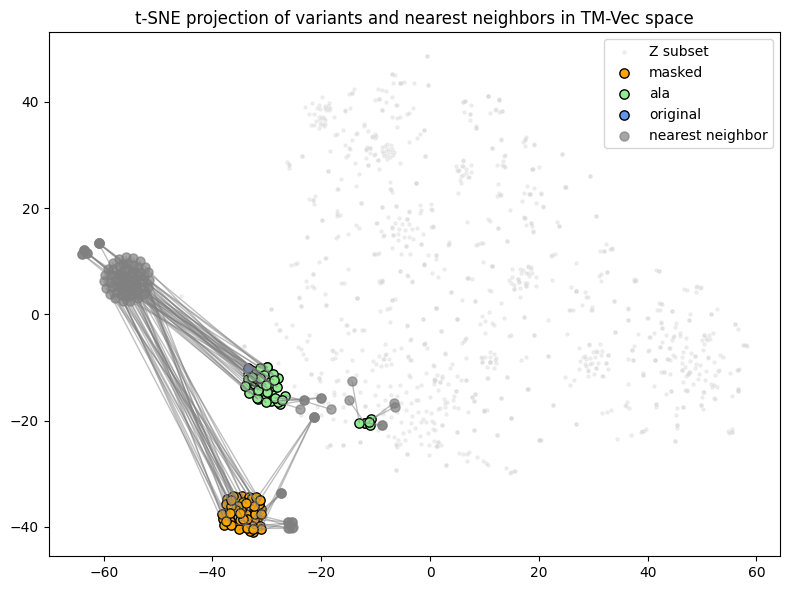

In [18]:
# ------------------------------------------------------------
# Example usage
# ------------------------------------------------------------
Z, metadata = load_tmvec_embeddings(source="cath", size="large", frac=1)
visualize_tmvec_mapping("../../data/embeddings/1VII_very_hard.npz", Z, metadata)